In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm
from tqdm import tqdm

In [3]:
size = 100

In [4]:
def sigmoid(x, alpha):
    z = np.exp(-x+alpha)
    sig = 1 / (1 + z)
    return sig

In [5]:
#Categorical data
x_1 = np.random.normal(40, 10, size = size)
x_2 = np.random.binomial(1,0.65, size = size)
y = np.around(sigmoid(x_1+x_2*20, alpha = 50)).astype(int)
synth_cat = pd.DataFrame({"y": y, "x_1":x_1, "x_2":x_2})
synth_cat_test = synth_cat.iloc[:round(0.3*size),:]
synth_cat_train = synth_cat.iloc[round(0.3*size):,:]

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
def data_remover_cat(full_data, missing_col, missing_pct, missing = "mar", impute = "cca"):
    #Missing_pct is in the range 0 to 100
    data = full_data.copy()

    if missing =="mar":
        x = data.drop(missing_col, axis = 1)
        if data[missing_col].nunique() ==2:
            clf = LogisticRegression(random_state=0).fit(x, data[missing_col])
            preds = clf.predict_proba(x)[:,1]
        else:
            clf = LinearRegression().fit(x, data[missing_col])
            preds = clf.predict(x)
        #print(preds)
        lower_percentile = np.percentile(preds, missing_pct//2)
        upper_percentile = np.percentile(preds, 100-missing_pct//2)
        """print("lower", lower_percentile,
            "upper", upper_percentile,
            "filtered", preds[(preds>=lower_percentile)&(preds<=upper_percentile)])
        
        #print("Mask", sum((data["preds"]<= lower_percentile)| (data["preds"]>= upper_percentile)))"""
        data["preds"] = preds
        data[missing_col] = data[missing_col].mask((data["preds"]<= lower_percentile) | (data["preds"]>= upper_percentile),
            other = np.nan)
        data.drop("preds", axis = 1, inplace = True)
        
    else:
        mcar = np.random.binomial(n=1, p=missing_pct/100, size = len(data))
        data["missing"] = [np.nan if m ==1 else 0 for m in mcar]
        data[missing_col] = data[missing_col].mask(data["missing"] == np.nan,
            other = np.nan)
        data.drop("missing", axis = 1, inplace = True)
        
    if impute =="cca":
        data.dropna(axis = 0, inplace = True)
    elif impute == "mean":
        if data[missing_col].nunique() ==2:
            #print("nans", data[missing_col].isna().sum())
            mode = data[missing_col].mode(dropna = True)[0]
            #print("mode", mode, "END")
            data[missing_col] = data[missing_col].fillna(mode)
            #print("nans", data[missing_col].isna().sum())
        else:
            mean = data[missing_col].mean(skipna = True)
            data[missing_col] = data[missing_col].fillna(mean)
    elif impute == "reg":
        pass
    elif impute == "mice_def":
        imputer = IterativeImputer(random_state=0)
        imputer.fit(data)
        data = pd.DataFrame(imputer.transform(data), columns = data.columns)
        #print(data[missing_col].unique())
        if data[missing_col].nunique() ==2:
            data[missing_col] = data[missing_col].round()
        #print(data[missing_col].unique())
    elif impute == "mice_reg":
        if data[missing_col].nunique() ==2:
            model = LogisticRegression(random_state=0, max_iter=300)
            imputer = IterativeImputer(estimator = model, random_state=0)
            imputer.fit(data)
            data = pd.DataFrame(imputer.transform(data), columns = data.columns)
            #print(data[missing_col].unique())
        else:
            model = LinearRegression()
            imputer = IterativeImputer(estimator = model, random_state=0)
            imputer.fit(data)
            data = pd.DataFrame(imputer.transform(data), columns = data.columns)
    return data




In [7]:
print("Class 1: ",len(synth_cat_train[synth_cat_train["x_2"]==1])/len(synth_cat_train) ,
    "\nClass 2: ", len(synth_cat_train[synth_cat_train["x_2"]==0])/len(synth_cat_train))
temp = synth_cat_train.copy()
temp = data_remover_cat(temp, "x_2", 30)
print("Class 1: ",len(temp[temp["x_2"]==1])/len(temp) ,
    "\nClass 2: ", len(temp[temp["x_2"]==0])/len(temp))

Class 1:  0.6571428571428571 
Class 2:  0.34285714285714286
Class 1:  0.7291666666666666 
Class 2:  0.2708333333333333


In [28]:
temp.columns = ["resp", "x_1", "x_2"]

In [8]:
import pymc3 as pm

In [29]:
simple_model = "x_2~x_1+resp"

In [30]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(simple_model,
                            temp,
                            family=pm.glm.families.Binomial())

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


In [34]:


with logistic_model:
    trace = pm.sample(tune=6000,
                         draws=2000,
                         chains = 5,
                         init = 'adapt_diag',
                         cores=5)



Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [resp, x_1, Intercept]


Sampling 5 chains for 6_000 tune and 2_000 draw iterations (30_000 + 10_000 draws total) took 679 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\mariu\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x_1'}>,
        <AxesSubplot:title={'center':'x_1'}>],
       [<AxesSubplot:title={'center':'resp'}>,
        <AxesSubplot:title={'center':'resp'}>]], dtype=object)

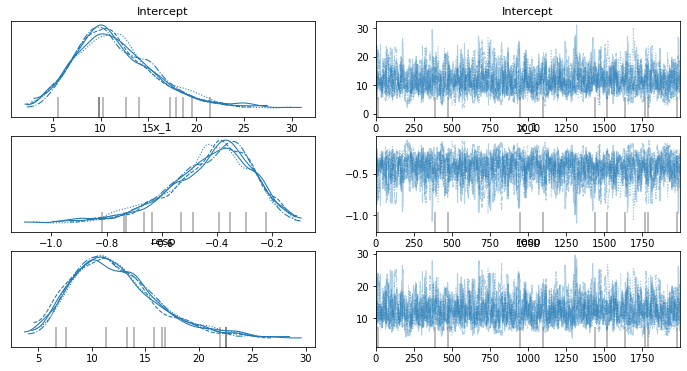

In [35]:
pm.plot_trace(trace)

In [36]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\mariu\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,11.568,4.191,4.304,19.557,0.121,0.086,1137.0,986.0,1.0
x_1,-0.423,0.151,-0.701,-0.149,0.004,0.003,1099.0,863.0,1.0
resp,12.216,4.011,5.395,20.022,0.116,0.082,1114.0,987.0,1.0


In [41]:

with logistic_model:
    trace = pm.sample(tune=10000,
                         draws=2000,
                         init = 'adapt_diag',
                         cores=5)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [resp, x_1, Intercept]


Sampling 5 chains for 10_000 tune and 2_000 draw iterations (50_000 + 10_000 draws total) took 1096 seconds.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7040111555120793, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\mariu\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'x_1'}>,
        <AxesSubplot:title={'center':'x_1'}>],
       [<AxesSubplot:title={'center':'resp'}>,
        <AxesSubplot:title={'center':'resp'}>]], dtype=object)

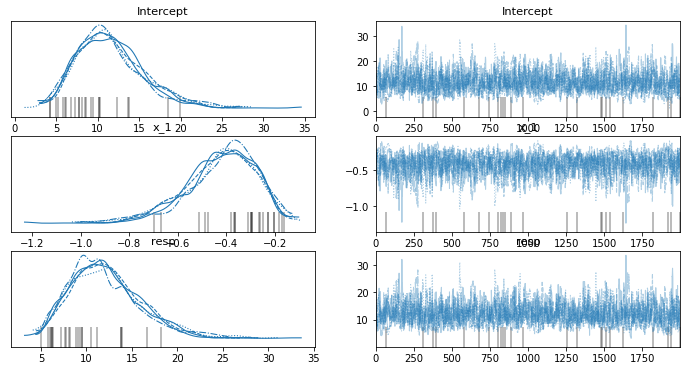

In [42]:
pm.plot_trace(trace)

In [43]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\mariu\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,11.513,4.023,4.920,19.536,0.121,0.086,1102.0,1346.0,1.0
x_1,-0.421,0.146,-0.699,-0.172,0.004,0.003,1064.0,1333.0,1.0
resp,12.121,3.855,5.634,19.446,0.116,0.082,1082.0,1430.0,1.0


In [39]:
basic_model = pm.Model()

with basic_model:
    x1 = pm.Normal('x1', mu=30, sigma=5, observed=temp["x_1"])
    res = pm.Beta("resp",1, 1, observed=temp["resp"])
    trace = pm.sample(tune=6000,
                         draws=1000,
                         init = 'adapt_diag',
                         cores=5)

C:\Users\mariu\AppData\Roaming\Python\Python39\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\mariu\AppData\Roaming\Python\Python39\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log1p
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\mariu\AppData\Roaming\Python\Python39\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\mariu\AppData\Roaming\Python\Python39\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)


ValueError: The model does not contain any free variables.

In [22]:
pm.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\mariu\AppData\Roaming\Python\Python39\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x1,30.116,5.053,20.556,39.453,0.076,0.055,4429.0,2672.0,1.0
x2,0.499,0.290,0.030,0.967,0.004,0.003,3954.0,2017.0,1.0
y,0.502,0.293,0.009,0.949,0.004,0.003,4332.0,2475.0,1.0
